In [1]:
%matplotlib inline

In [2]:
from io import BytesIO
import base64

In [3]:
import pandas
pandas.options.display.max_rows = 100

import matplotlib.pyplot as plt

In [13]:
raw_data = pandas.read_json("corona.json")
data = raw_data.drop(columns=["link", "new_reg", "total_reg"]).fillna(0)
regions = data.drop(columns=["new", "total", "total_healthy"]).set_index("date")

In [15]:
regions['total'] = regions.sum(axis=1)

In [17]:
def speed(series):
    return series[0:7].sum() / series[7:14].sum()

def weekly(series):
    return series[:7].sum()

def last_weekly(series):
    return series[7:14].sum()

def figure(series):
    fig, ax = plt.subplots(figsize=(1.0, 0.5));
    series[:21].plot(ax=ax)
    ax.set_ylim(0.0, series[:21].max() * 1.1)
    ax.set_xlabel("")
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([series.index[0], series.index[6], series.index[13]])
    ax.set_yticks([])
    plt.close()
    
    with BytesIO() as buffer:
        fig.savefig(buffer, format='png')
        b64 = base64.b64encode(buffer.getvalue()).decode()
    
    return f'<img src="data:image/png;base64,{b64}">'    

    return fig

In [18]:
data_agg = pandas.DataFrame({
    "This week / Last week": regions.apply(speed),
    "This week": regions.apply(weekly),
    "Last week": regions.apply(last_weekly),
    "21 day": regions.apply(figure)
}).sort_values("This week", ascending=False)

In [19]:
print(regions.index[0])

2020-10-18 00:00:00


,This week / Last week,This week,Last week,21 day
total,1.20186,100616,83717,
Москва,1.20232,31835,26478,
Санкт-Петербург,1.33467,4315,3233,
Московская область,1.12101,3094,2760,
Ростовская область,1.08411,1972,1819,
Нижегородская область,1.20626,1965,1629,
Свердловская область,1.17302,1539,1312,
Воронежская область,1.1324,1531,1352,
Архангельская область,1.07011,1450,1355,
Красноярский край,1.28506,1411,1098,

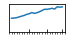
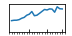
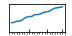
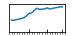
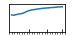
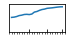
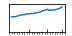
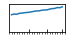
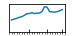
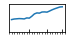
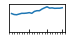
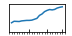
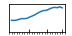
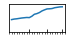
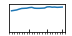
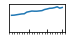
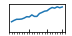
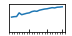
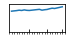
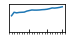
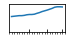
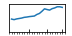
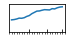
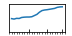
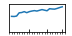
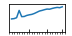
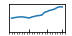
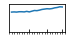
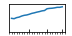
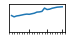
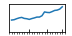
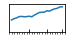
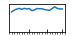
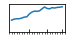
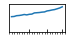
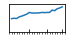
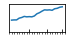
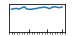
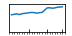
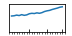
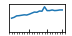
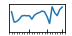
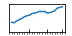
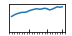
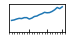
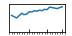
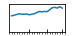
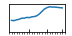
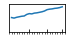
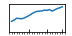
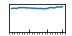
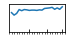
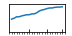
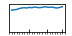
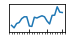
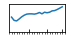
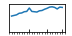
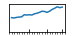
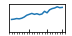
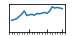
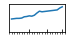
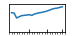
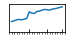
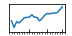
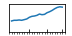
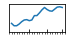
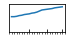
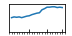
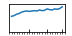
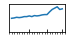
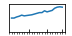
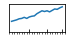
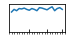
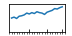
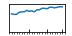
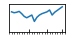
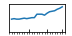
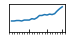
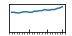
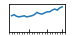
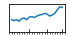
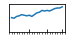
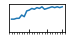
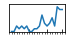
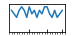
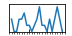

In [20]:
data_agg.style.bar("This week / Last week")